# Analyzing the NYC Subway Dataset

Craig Nicholson
September 9th 2015

In this notebook, we will review look the NYC Subway data and determine if more people ride the subway when it is raining versus when it is not raining.

## Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
# display plot within the notebook rather than a new window
%pylab inline


Populating the interactive namespace from numpy and matplotlib


## Load the Data

In [3]:
# load the stroopdata.csv
path = '~/Downloads/P2-1/turnstile_weather_v2.csv'
df = pd.read_csv(path)

In [4]:
# fetch two samples, the one with rain and the one without rain
# 1 = rain, 0 = no rain for the entry
# reset the indexes since we have new dataframes
rain = df[df['rain']==1].reset_index()
norain =  df[df['rain']==0].reset_index()

## Section 1. Statistical Test

The mean difference of people ride the subway when it is raining versus when it is not raining.
#### null Hypothesis
H0: μd = μ0
#### Alternate Hypothesis
HA: μd ≠ μ0
#### Statistical Test
Since we have one large sample and are reviewing riders on the days it is raining vs. not raining we will run an Independant T-test.  And the ENTRIESn_hourly occurs over a date range.
#### Independant variables
Rain vs No Rain
#### Dependent variable
The number of ENTRIESn_hourly

## Data Validation

any mising dates  
are all dates valid  
any missing ENTRIESn_hourly  
any missing hours, any hours out of the correct date?  
we have day_week can we use this for the weekend   
do we have folks using more UNITs in other areas more than others...   
what happens on the weekend with the data...  
when it rains does it rain for all hours in the day or just like early in the AM...
what is the hourly entries like throughout the day... 


## Calculations

In [5]:
# t-test via scipy  - run this first , and then review and calculate to learn the math
# returns t-statistic and two-tailed p-value
# equal_var = False, perform Welch’s t-test, which does not assume equal population 
# Welch does not assume equal sample size or equal variences
# returns 5.33
t_test_results = stats.ttest_ind(rain['ENTRIESn_hourly'],norain['ENTRIESn_hourly']
                                 ,equal_var = False)
t_statistic = t_test_results[0]
p_value = t_test_results[1]
print'Welch''s t-test: ', t_statistic, p_value

# note to self, how do I determine the direction, of the shift... by the mean?
# if the mean for rain is higher than no rain... this is a right shift.
# is this the typical implementation 

# returns -5.33
t_test_results = stats.ttest_ind(norain['ENTRIESn_hourly'],rain['ENTRIESn_hourly']
                                 ,equal_var = True)

# returns 5.33
t_test_results = stats.ttest_ind(rain['ENTRIESn_hourly'],norain['ENTRIESn_hourly']
                                 ,equal_var = True)

t_statistic = t_test_results[0]
p_value = t_test_results[1]
print t_statistic, p_value

Welchs t-test:  5.04288274762 4.64140243163e-07
5.33483986013 9.61154838577e-08


In [6]:
# The Mann-Whitney U test is used to compare differences between two independent groups 
# when the dependent variable is either ordinal or continuous, but not normally distributed. 
# Returns The Mann-Whitney statistics, p-value (one sided)
# Mann-Whitney U is significant if the u-obtained is LESS THAN or equal to the critical value of U
# I think this is insignificant here... because of Mann Whitney.  Hard to figure out U critical value
# http://www.real-statistics.com/statistics-tables/mann-whitney-table/
# http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Nonparametric/BS704_Nonparametric4.html
# 
u_statistic, mannwhitney_p_value = stats.mannwhitneyu(rain['ENTRIESn_hourly'], norain['ENTRIESn_hourly']
                                                      , use_continuity=True)
print u_statistic,mannwhitney_p_value

153635120.5 2.74106957124e-06


In [7]:
# Get the (n) number of samples in each 
rain_n = rain['UNIT'].count() 
norain_n = norain['UNIT'].count() 

# Get the (df) number of samples in each 
# We are using the independent t test 
rain_df = rain_n-1
norain_df = norain_n-1
pooled_df = rain_df+norain_df

In [8]:
# Get the means and medians for the rain
rain_xbar= rain['ENTRIESn_hourly'].mean()
rain_median = rain['ENTRIESn_hourly'].median()

# Get the means and medians for the norain
norain_xbar = norain['ENTRIESn_hourly'].mean()
norain_median = norain['ENTRIESn_hourly'].median()

In [9]:
# Get the standard deviations of the samples
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html
rain_sd = stats.tstd(rain['ENTRIESn_hourly'], limits=None, inclusive=(True, True))
norain_sd = stats.tstd(norain['ENTRIESn_hourly'], limits=None, inclusive=(True, True))

# Standard Error of the Mean
# I need to run this calculations myself and valiate the independant test
rain_se = stats.sem(rain['ENTRIESn_hourly'], axis=None, ddof=rain_df)
norain_se = stats.sem(norain['ENTRIESn_hourly'], axis=None, ddof=norain_df)
print rain_se, norain_se

3189.26699226 2878.72731433


In [10]:
# Calculate the t-critical value, instead of using a table - woohoo
# http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.t.html
# By adding 1 to 0.95 and then dividing by 2, we get the critical value for 2 tail test
degrees_of_freedom = pooled_df
#critical_value = stats.t._ppf((1+0.95)/2., degrees_of_freedom)
critical_value = stats.t._ppf((1+0.99)/2., degrees_of_freedom)

In [11]:
# Calculate Sum of Squares (SS for rain), pooled var, pooled SE
# (X1 - XBar)**2
rain_SS = np.sum((rain['ENTRIESn_hourly']-rain_xbar)**2)
norain_SS = np.sum((norain['ENTRIESn_hourly']-norain_xbar)**2)
print rain_SS,norain_SS

97493098540.7 2.74003713901e+11


In [12]:
# Validate the above equation for rain
rain['dff_mean_var']  = rain['ENTRIESn_hourly']-rain_xbar
rain['SS'] = np.square(rain['dff_mean_var'])

# Validate the above equation for rain
norain['dff_mean_var']  = norain['ENTRIESn_hourly']-norain_xbar
norain['SS'] = np.square(norain['dff_mean_var'])
print  rain['SS'].sum(), norain['SS'].sum()

# Calculate the Standard Error for each for checking scipy and learning std error
print np.sqrt(rain['SS'].sum()/rain_df), np.sqrt(norain['SS'].sum()/norain_df)

97493098540.7 2.74003713901e+11
3189.43337288 2878.77084798


In [13]:
# Pooled Varience is the Total of the Sum of Squares  / Total df
pooled_varience = (rain_SS+norain_SS)/(pooled_df)
print pooled_varience

8710971.75513


In [14]:
# Corrected Standard Error is the Total of the Sum of Squares  / Total Degrees of freedom
# SE Corrected with pooled var
# divide by n- sample size not df.
# the standard error is never negative
# Pooled Variance Sum of Squares has some corrections it uses the df instead of the sample sizes
pooled_SE = np.sqrt(pooled_varience/rain_n + pooled_varience/norain_n)
print pooled_SE

34.2384404399


In [15]:
# calculate the t-statistic, to compare with scipy
t_stat_check = (rain_xbar-norain_xbar)/pooled_SE
print t_stat_check

5.33483986013


In [16]:
# r squared
r_squared = ( np.square(t_statistic) /  (np.square(t_statistic) + (degrees_of_freedom)  ))

In [17]:
# Cohens D
cohens_d = (rain_xbar-norain_xbar)/pooled_varience

In [18]:
# Calculate Confidence Intervals Independent Samples
# SE +/- (t_critical * SE) 
# https://www.udacity.com/course/viewer#!/c-ud134-nd/l-4576163829/e-154863542/m-154863544
lower_CI = (rain_xbar-norain_xbar)-(critical_value*pooled_SE)
upper_CI = (rain_xbar-norain_xbar)+(critical_value*pooled_SE)

### 1.1 Which statistical test did you use to analyze the NYC subway data? 
The independent-samples t-test (or independent t-test, for short) compares the means between two unrelated groups on the same continuous, dependent variable.

The independent t-test, also called the two sample t-test or student's t-test, is an inferential statistical test that determines whether there is a statistically significant difference between the means in two unrelated groups.

### Did you use a one-tail or a two-tail P value?
A two-tail test is used to analze the data.

### What is the null hypothesis?
There is no difference in hourly entries for rainy and non rainy days:

H0: u1 = u2

HA: u1 ≠ u2  
note: In most cases, we are looking to see if we can show that we can reject the null hypothesis and accept the alternative hypothesis, which is that the population means are not equal:


### What is your p-critical value?
t-critical is +/- 2.58  
p critical is 0.001 (alpha) 


### 1.2 Why is this statistical test applicable to the dataset?

We have two unrelated groups on the same continuous, dependent variable, with different sample sizes.

###  In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

#### Assumption of normality of the dependent variable - ANSWERED
The independent t-test requires that the dependent variable is approximately normally distributed **within each group**. We can test for this using a multitude of tests, but the Shapiro-Wilks Test or a graphical method, such as a Q-Q Plot, are very common. 

However, the t-test is described as a robust test with respect to the assumption of normality. This means that even deviations away from normality do not have a large influence on Type I error rates. The exception to this is if the difference in the size of the groups is greater than 1.5 (largest compared to smallest).

RAIN IS 3.44 times smaller than no rain hourly entries so it possible to be un normal.

Our distributions are skewed distributions in the positive direction.  The distributions are similar.

A distribution is skewed if one of its tails is longer than the other. The first distribution shown has a positive skew. This means that it has a long tail in the positive direction. The distribution below it has a negative skew since it has a long tail in the negative direction.

We do not have a normal distribution.  The values are not equally distributed about the mean.


#### What to do when you violate the normality assumption
(2) run the Mann-Whitney U Test which is a non-parametric test that does not require the assumption of normality (to run this test in SPSS see our guide on the Mann-Whitney U Test).

#### Assumption of Homogeneity of Variance
The independent t-test assumes the variances of the two groups you are measuring to be equal. 

If your variances are unequal, this can affect the Type I error rate. The assumption of homogeneity of variance can be tested using Levene's Test of Equality of Variances, which is produced in SPSS when running the independent t-test. If you have run Levene's Test of Equality of Variances, whether in SPSS or by another means, you will get a result similar to that below:

Levene's Test for Equality of Variances in the Independent T-Test Procedure within SPSS
This test for homogeneity of variance provides an F statistic and a significance value (p-value). We are primarily concerned with the significance level - if it is greater than 0.05, our group variances can be treated as equal. However, if p < 0.05, we have unequal variances and we have violated the assumption of homogeneity of variance.



https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php

In [19]:
# Descovery
rain['ENTRIESn_hourly'].describe()
norain['ENTRIESn_hourly'].describe()

count    33064.000000
mean      1845.539439
std       2878.770848
min          0.000000
25%        269.000000
50%        893.000000
75%       2197.000000
max      32814.000000
Name: ENTRIESn_hourly, dtype: float64

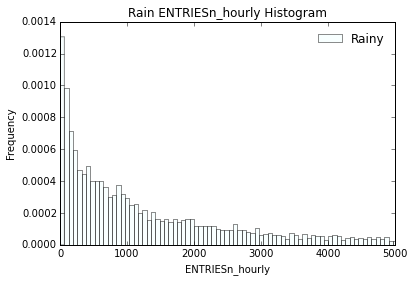

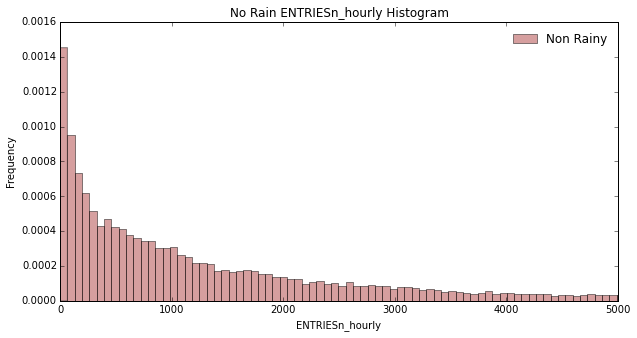

In [20]:
# Histogram - These plots have the same shape - but does this mean they are normally distributed or just
# normally distributed together as a group/pair
plt.hist(rain['ENTRIESn_hourly'], bins=500, normed=True, alpha=0.45, label='Rainy',color='azure')
plt.title('Rain ENTRIESn_hourly Histogram')
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Frequency')
plt.legend(loc='best', frameon=False)
# resize to show the distribution of the data
plt.axis(xmin=0, xmax=5000)
plt.figure(figsize(10,5))


#df['ENTRIESn_hourly'].hist(by=df['rain'], figsize=(10, 10), bins=10,alpha=0.5 label='Craig')
plt.hist(norain['ENTRIESn_hourly'], bins=500, normed=True, alpha=0.45, label='Non Rainy',color='brown')
plt.title('No Rain ENTRIESn_hourly Histogram')
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Frequency')
plt.legend(loc='best', frameon=False)
# resize to show the distribution of the data
plt.axis(xmin=0, xmax=5000)
plt.figure(figsize(10,5))

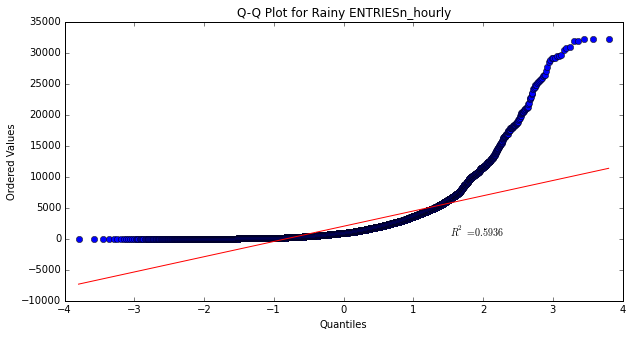

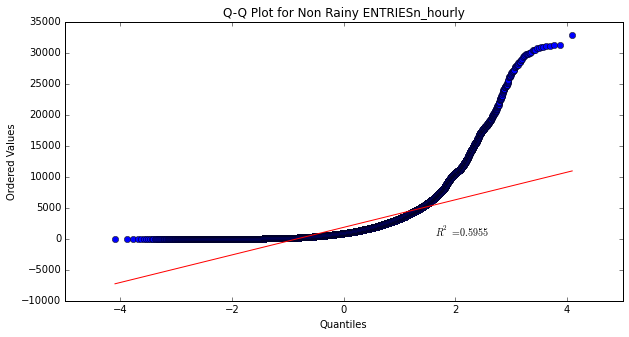

In [21]:
# Q-Q plot to test for normal distribution
# http://stackoverflow.com/questions/13865596/quantile-quantile-plot-using-scipy
stats.probplot(rain['ENTRIESn_hourly'], dist="norm", plot=pylab)
pylab.title('Q-Q Plot for Rainy ENTRIESn_hourly')
pylab.show()

stats.probplot(norain['ENTRIESn_hourly'], dist="norm", plot=pylab)
pylab.title('Q-Q Plot for Non Rainy ENTRIESn_hourly')
pylab.show()

In [22]:
# Shapiro-Wilks Test for normal distribution
# scipy.stats.shapiro(x, a=None, reta=False)[source]¶
# http://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm
#Returns:
# W : The test statistic.
# p-value : The p-value for the hypothesis test.
# a : array_like, optional
stats.shapiro(df['ENTRIESn_hourly'], a=None, reta=True)

/home/cnicholson/anaconda/lib/python2.7/site-packages/scipy/stats/morestats.py:997: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.5943876504898071,
 0.0,
 array([  2.13032681e-02,   1.93585046e-02,   1.85939576e-02, ...,
          8.53702829e-07,   5.69376368e-07,   2.84688184e-07], dtype=float32))

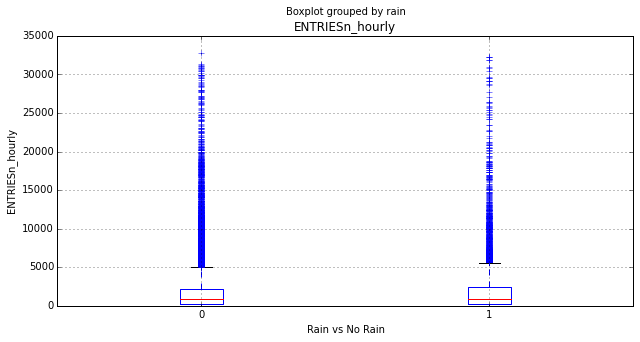

In [23]:
# Check for outliers
x_sec = df[['rain', 'ENTRIESn_hourly']]
plt.figure()
bp = x_sec.boxplot(by='rain')
plt.xlabel("Rain vs No Rain")
plt.ylabel("ENTRIESn_hourly")

DONE: Assumption #1: Your dependent variable should be measured on a continuous scale (i.e., it is measured at the interval or ratio level). Examples of variables that meet this criterion include revision time (measured in hours), intelligence (measured using IQ score), exam performance (measured from 0 to 100), weight (measured in kg), and so forth. You can learn more about continuous variables in our article: Types of Variable.

DONE: Assumption #2: Your independent variable should consist of two categorical, independent groups. Example independent variables that meet this criterion include gender (2 groups: male or female), employment status (2 groups: employed or unemployed), smoker (2 groups: yes or no), and so forth.

DONE: Assumption #3: You should have independence of observations, which means that there is no relationship between the observations in each group or between the groups themselves. For example, there must be different participants in each group with no participant being in more than one group. This is more of a study design issue than something you can test for, but it is an important assumption of the independent t-test. If your study fails this assumption, you will need to use another statistical test instead of the independent t-test (e.g., a paired-samples t-test). If you are unsure whether your study meets this assumption, you can use our Statistical Test Selector, which is part of our enhanced content.

Assumption #4: There should be no significant outliers. Outliers are simply single data points within your data that do not follow the usual pattern (e.g., in a study of 100 students' IQ scores, where the mean score was 108 with only a small variation between students, one student had a score of 156, which is very unusual, and may even put her in the top 1% of IQ scores globally). 

The problem with outliers is that they can have a negative effect on the independent t-test, reducing the validity of your results. 

WE HAVE LOTS OF OUTLIERS.  NEED TO CONFIRM


https://statistics.laerd.com/spss-tutorials/independent-t-test-using-spss-statistics.php

### 1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

In [24]:
print '\n'
print 'TABLE 1.0'
print '\n'
print 'DESCRIPTIVE STATISTICS'
print '\t\tn \t\tmean \t\tmedian \t\tStDev \t\tSE Mean'
print 'Rain   \t\t%.2f \t%.2f \t%.2f \t\t%.2f \t%.2f' % (rain_n,rain_xbar, rain_median,rain_sd,rain_se)
print 'No Rain\t\t%.2f \t%.2f \t%.2f \t\t%.2f \t%.2f' % (norain_n,norain_xbar,norain_median,norain_sd,norain_se)
print '\n'
print 'Pooled Varience: \t\t%.0f' % pooled_varience
print 'Corrected Standard Error: \t%.3f' % pooled_SE
print '\n'

print 'INFERENTIAL STATISTICS'
# Paired t-test, two tail, t-statistic ,df,p-value, direction of test (two tail, or one tail to in _/- directrion')
print 'Type of test\t\t\t = %s' % 'Independent t-test'
print 'Test statistics: T \t\t = %.5f' % t_statistic
print 'Degrees of Freedom\t\t = %.0f' % ((rain_n+norain_n)-2)
print 'Significance Level: alpha \t = %s ' % '0.01'
print 'Critical value: t1-α/2,ν \t = %.2f' % critical_value
print 'Critical region: Reject H0 if \t = |T| > %.2f' % critical_value
print 'P-Value\t\t\t\t = %.9f' % p_value
print 'Direction of test\t\t = %s ' % 'two tail'
print '\n'

print 'CONFIDENCE INTERVALS'
print '99%% CI for the mean difference: (%.5f, %.5f)' % (lower_CI,upper_CI)
print 'Margin of Error: %.2f' % ((upper_CI-lower_CI)/2.0)
print '\n'

print 'EFFECT SIZE MEASURES'
print 'r squared \t\t\t = %.5f' % r_squared 
print 'Cohens-D\t\t\t = %.5f' % cohens_d
print '\n'



TABLE 1.0


DESCRIPTIVE STATISTICS
		n 		mean 		median 		StDev 		SE Mean
Rain   		9585.00 	2028.20 	939.00 		3189.43 	3189.27
No Rain		33064.00 	1845.54 	893.00 		2878.77 	2878.73


Pooled Varience: 		8710972
Corrected Standard Error: 	34.238


INFERENTIAL STATISTICS
Type of test			 = Independent t-test
Test statistics: T 		 = 5.33484
Degrees of Freedom		 = 42647
Significance Level: alpha 	 = 0.01 
Critical value: t1-α/2,ν 	 = 2.58
Critical region: Reject H0 if 	 = |T| > 2.58
P-Value				 = 0.000000096
Direction of test		 = two tail 


CONFIDENCE INTERVALS
99% CI for the mean difference: (94.46027, 270.85292)
Margin of Error: 88.20


EFFECT SIZE MEASURES
r squared 			 = 0.00067
Cohens-D			 = 0.00002




### 1.4 What is the significance and interpretation of these results?

We Reject the null hypothesis.

Inspection of Q-Q Plots revealed that ENTRIESn_hourly was NOT normally distributed for both groups and that there was homogeneity of variance as assessed by Levene's Test for Equality of Variances.  TODO

Therefore, an independent t-test was run on the data as well as 99% confidence intervals (CI) for the mean difference. It was found during days with rain, the ENTRIESn_hourly (2028.20  ± 3189.43) were significantly higher than the days with No Rain (1845.54 ± 2878.77). 

(t(42647) = 5.33484, p < 0.001) with a difference of 182.66 (99% CI, 94.46 to 270.85) ENTRIESn_hourly.

THIS NEEDS SOME WORK

## Section 2. Linear Regression


### 2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model: OLS using Statsmodels or Scikit Learn Gradient descent using Scikit Learn Or something different?

In [25]:
values  = df['ENTRIESn_hourly']
#features = df[["meanprecipi","rain","tempi","hour","day_week"]]
#features = df[["meanprecipi","rain","hour","day_week"]]
features = df[["meanprecipi","rain","hour","day_week","meanwspdi"]]

dummy_units = pd.get_dummies(df['UNIT'], prefix='unit')
features = features.join(dummy_units)
    
Y = values
X = features
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
intercept =  results.params[0]
params = results.params

intercept, params

# ENTRIESn_hourly = -4.44 * height + 0.92 * weight + 199.07
print results.summary()


predictions = intercept + np.dot(features, params[1:])

                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     153.7
Date:                Fri, 11 Sep 2015   Prob (F-statistic):               0.00
Time:                        23:52:39   Log-Likelihood:            -3.8778e+05
No. Observations:               42649   AIC:                         7.761e+05
Df Residuals:                   42404   BIC:                         7.782e+05
Df Model:                         244                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        1066.4262     46.483     22.943      

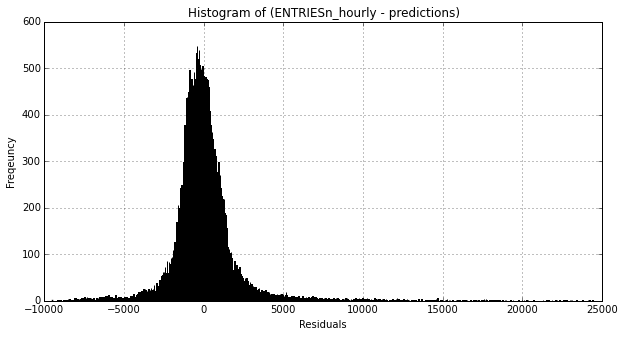

In [26]:
residuals = df['ENTRIESn_hourly'] - predictions
plt.figure()
residuals.hist(bins=1000)
plt.title(r'Histogram of (ENTRIESn_hourly - predictions)')
plt.xlabel('Residuals')
plt.ylabel('Freqeuncy')

### 2.2 What features (input variables) did you use in your model? 

In [27]:
results.params[:6]

const          1066.426238
meanprecipi     987.886208
rain            112.614241
hour            123.319458
day_week       -145.869128
meanwspdi       -10.731987
dtype: float64

### Did you use any dummy variables as part of your features? 
Yes.  Hourly entries are associated to a turnstyle which can be in a heavy populated area to a less populated area of New York.   So using the turnstyles as dummy variables one is able to make better predications.

Example:

In [28]:
results.params[7:10]

unit_R004   -1259.291608
unit_R005   -1259.284160
unit_R006   -1145.479635
dtype: float64


### 2.3 Why did you select these features in your model? 

We are looking for specific reasons that lead you to believe that the selected features will contribute to the predictive power of your model. Your reasons might be based on intuition. For example, response for fog might be: “I decided to use fog because I thought that when it is very foggy outside people might decide to use the subway more often.” Your reasons might also be based on data exploration and experimentation, for example: “I used feature X because as soon as I included it in my model, it drastically improved my R2 value.”

### 2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model? 

In [29]:
results.params[:6]

const          1066.426238
meanprecipi     987.886208
rain            112.614241
hour            123.319458
day_week       -145.869128
meanwspdi       -10.731987
dtype: float64

### 2.5 What is your model’s R2 (coefficients of determination) value?

In [30]:
SST = ((df['ENTRIESn_hourly']-np.mean(df['ENTRIESn_hourly']))**2).sum()
SSReg = ((predictions-df['ENTRIESn_hourly'])**2).sum()
r_squared = 1 - (SSReg/SST)
print r_squared

0.469380561687


### 2.6 What does this R2 value mean for the goodness of fit for your regression model? 




Additional Considerations:
OLS is guarantteed to find the optimal solution, where as Gradient Descent is not.   The closer your model is to 1 the better the model.   Our model seems to be not linear.

- Parameter Estimation:

What are the Confidence Intervals of the parameters?
What is the likely hood w
e would calculate this parameter value if the parameter had no effect on our output variable.

- Over and Under Fitting

###  Do you think this linear model to predict ridership is appropriate for this dataset, given this R2 value?
No.  OLS


## Section 3. Visualization

Please include two visualizations that show the relationships between two or more variables in the NYC subway data.  

Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure.



### 3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.

(0, 6000)

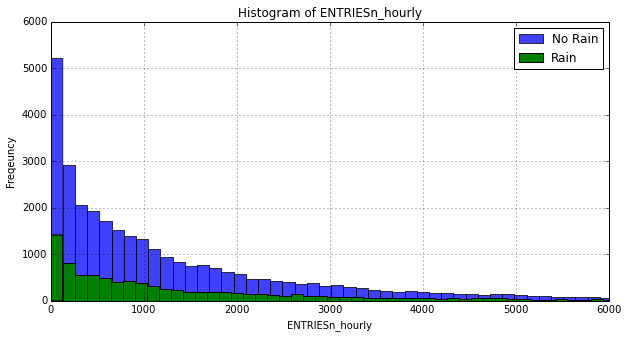

In [35]:
plt.figure()
#bins
binSize = 250
# your code here to plot a historgram for hourly entries when it is not raining
norain['ENTRIESn_hourly'].hist(color='blue', label='No Rain', bins=binSize,alpha=0.75)
# your code here to plot a historgram for hourly entries when it is raining
rain['ENTRIESn_hourly'].hist(color='green',label='Rain',bins=binSize)
plt.legend()
plt.title(r'Histogram of ENTRIESn_hourly')
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Freqeuncy')
plt.xlim(0,6000)

Does the data seem normally distributed?    
NO

Do you think we would be able to use Welch's t-test on this data?  
No.  The data is not normally distributed.

## 3.2 One visualization can be more freeform. 

You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:
Ridership by time-of-day
Ridership by day-of-week

Do people ride more on the weekend....?

## Section 4. Conclusion

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### 4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?

### 4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.

## Section 5. Reflection

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### 5.1 Please discuss potential shortcomings of the methods of your analysis, including: Dataset, Analysis, such as the linear regression model or statistical test.

### 5.1 Please discuss potential shortcomings of the methods of your analysis, including: Dataset, Analysis, such as the linear regression model or statistical test.

# Referenecs

Python 3.4.2 Documentation     
Retrieved from https://docs.python.org/

ggplot from yhat   
Retrieved from http://ggplot.yhathq.com/

SciPy.org    
Retrieved from http://scipy.org/

Engineering Statistics    
Retrieved from http://www.itl.nist.gov/div898/handbook/

5.2.4.  Are the model residuals well-behaved? [Blog Post]   
Retrieved from http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm

The Minitab Blog What Is the Difference between Linear and Nonlinear Equations in Regression Analysis? [Blog Post]  
Retrieved from http://blog.minitab.com/blog/adventures-in-statistics 

The Minitab Blog Regression Analysis how do I interpret R Squared and assess the goodness of fit. [Blog Post]  
Retrieved from http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit

What are the differences between one-tailed and two-tailed tests? [Blog Post]   
Retrieved from http://www.ats.ucla.edu/stat/mult_pkg/faq/general/tail_tests.htm

Dummy Variables [Wiki Post]   
Retrieved from http://en.wikipedia.org/wiki/Dummy_variable_(statistics) 

Mann-Whitney U Test using SPSS [Blog Post]   
Retrieved from https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.phpRegression 

Independent T-Test for Two Samples [Blog Post]   
Retrieved from https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php

Analysis – How to Interpret the Constant Y Intercept [Blog Post]   
Retrieved from http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-to-interpret-the-constant-y-intercept 

Coding in the Rain [Blog Post]   
Retrieved From http://drjasondavis.com/2013/07/08/coding-in-the-rain/ 

Mann-Whitney U Test using SPSS  
Retrieved From https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php
